<a href="https://colab.research.google.com/github/glee1228/net_VLad_keras/blob/master/netVLAD_triplet_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from keras.applications.nasnet import NASNetMobile
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications import VGG16
import tensorflow as tf
import keras
from keras import layers
from keras.preprocessing.image import array_to_img
from keras.models import Model
from keras.layers import Input, concatenate,merge
from keras.optimizers import Adam
from keras import optimizers
from keras import backend as K
from keras.layers import Layer
import keras
import code
import numpy as np
import math
from keras import initializers, layers

Using TensorFlow backend.


# NetVlad model Architecture


![대체 텍스트](https://www.di.ens.fr/willow/research/netvlad/images/vlad_cnn.png)

## keras Version implementation 

by glee1228@naver.com 

In [0]:
# !pip install tensorboardcolab
# from tensorboardcolab import TensorBoardColab
# tb = TensorBoardColab()

## Google Colab

In [3]:
from google.colab import drive
import os

if os.path.exists('/content/gdrive')==False:
    drive.mount('/content/gdrive')
    print('Google Drive is mounted\n')
else:
    print('Google Drive is already mounted\n')

Google Drive is already mounted



In [0]:
tf.set_random_seed(777)

## Parameter 

## **prof_team**

팀 계정에서 실행 : **True**

테스트용 : **False**

## **get_tripletset**

triplet set을 새로 뽑기 : **True**

else : **False**

## **train_test** 

True로 최소한 한번 실행해 model을 저장한 후 False로 놓고 실행합니다. True여도 test 결과는 출력합니다.

train mode : **True**

test mode : **False**


In [0]:
prof_team = False
get_tripletset = False
train_test = True

## Data Path

In [6]:
if prof_team :
  ckpt_path = '/content/gdrive/My Drive/AILeader_Dataset/Checkpoint_jw'
  train_path = './gdrive/My Drive/AILeader_Dataset/train'
  test_path = './gdrive/My Drive/AILeader_Dataset/test'
  ! ls -a ./gdrive/My\ Drive/AILeader_Dataset/train
  
else :
  ckpt_path = './gdrive/My Drive/ckpt'
  train_path = './gdrive/My Drive/train'
  test_path = './gdrive/My Drive/test'
  ! ls -a ./gdrive/My\ Drive/train

 AI	        dorm		   'Front door Sejong'	'Stone statue'
'Clock tower'  'Front door Child'   Museum


In [0]:
os.environ['CUDA_VISIBLE_DEVICES']= '0'

## NetVLAD Layer

In [0]:
# https://github.com/mpkuse/cartwheel_train/blob/master/CustomNets.py


class NetVLADLayer(Layer):

    def __init__( self, num_clusters, **kwargs ):
        self.num_clusters = num_clusters
        super(NetVLADLayer, self).__init__(**kwargs)

    def build( self, input_shape ):
        self.K = self.num_clusters
        self.D = input_shape[-1]


        self.kernel = self.add_weight( name='kernel',
                                    shape=(1,1,self.D,self.K),
                                    initializer='uniform',
                                    trainable=True )

        self.bias = self.add_weight( name='bias',
                                    shape=(1,1,self.K),
                                    initializer='uniform',
                                    trainable=True )

        self.C = self.add_weight( name='cluster_centers',
                                shape=[1,1,1,self.D,self.K],
                                initializer='uniform',
                                trainable=True)


    def call( self, x ):
        s = K.conv2d( x, self.kernel, padding='same' ) + self.bias
        a = K.softmax( s )
        self.amap = K.argmax( a, -1 )
        a = K.expand_dims( a, -2 ) 
        v = K.expand_dims(x, -1) + self.C 
        v = a * v
        v = K.sum(v, axis=[1, 2])
        v = K.permute_dimensions(v, pattern=[0, 2, 1])

        v = K.l2_normalize( v, axis=-1 )
        v = K.batch_flatten( v )
        v = K.l2_normalize( v, axis=-1 )
        
        # return [v, self.amap]
        return v

    def compute_output_shape( self, input_shape ):
        return (input_shape[0], self.K*self.D )

    def get_config( self ):
        pass
        # base_config = super(NetVLADLayer, self).get_config()
        # return dict(list(base_config.items()))

        # As suggested by: https://github.com/keras-team/keras/issues/4871#issuecomment-269731817
        config = {'num_clusters': self.num_clusters}
        base_config = super(NetVLADLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


## base model 

In [0]:
batch_size= 32
input_shape = (128,128,3)

In [0]:
from keras import Model, Input
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from keras.optimizers import SGD,Adam
from keras.models import Sequential

def initialize_model(backbone= None, input_shape=input_shape, use_pretrained = 'imagenet'):
  base_model = None
  dim = 0
  base_model = backbone(input_shape=input_shape, weights=use_pretrained, include_top= False)
  x = base_model.output
  dim = x[-1].get_shape().as_list()[2]
  
  return base_model, dim



In [0]:
## VGG16 or Xception or DenseNet121 or 
## DenseNet169 or DenseNet201 or NASNetMobile or 
## ResNet50 or InceptionResNetV2
model_name = VGG16  

In [12]:
base_model, dim =initialize_model(model_name, input_shape=input_shape)

print('dim : ',dim)

Instructions for updating:
Colocations handled automatically by placer.
dim :  512


## Triplet Sampler

In [0]:
train_triplet_num = 100
test_triplet_num = 10
img_width = 128
img_height = 128

### Train Triplets Pathes

In [14]:
train_dir_pathes = []
test_dir_pathes = []

i =0
for root,dir,file in os.walk(train_path):
  if i>=1:
    train_dir_pathes.append(root)
  i+=1
train_dir_pathes=sorted(train_dir_pathes)

i =0
for root,dir,file in os.walk(test_path):
  if i>=1:
    test_dir_pathes.append(root)
  i+=1
test_dir_pathes=sorted(test_dir_pathes)

print(train_dir_pathes)
print(test_dir_pathes) # class dir path

['./gdrive/My Drive/train/AI', './gdrive/My Drive/train/Clock tower', './gdrive/My Drive/train/Front door Child', './gdrive/My Drive/train/Front door Sejong', './gdrive/My Drive/train/Museum', './gdrive/My Drive/train/Stone statue', './gdrive/My Drive/train/dorm']
['./gdrive/My Drive/test/AI', './gdrive/My Drive/test/Clock tower', './gdrive/My Drive/test/Front door Child', './gdrive/My Drive/test/Front door Sejong', './gdrive/My Drive/test/Museum', './gdrive/My Drive/test/Stone statue', './gdrive/My Drive/test/dorm']


In [0]:
import numpy as np
import random
from PIL import Image


def get_triplets(triplet_num,img_width,img_height,dir_pathes):
  if 'train' in str(dir_pathes) :
    print('getting train data..!')
  else :
    print('getting test data..!')
  total_len =len(dir_pathes)*triplet_num
  print('total triplets length : {}'.format(total_len))
  triplets = np.zeros((total_len,3,img_width,img_height,3))

  triplets_len = 0
  for i in range(len(dir_pathes)):
      # set the files of anchor and positive images
      anc_pos_files = [f for f in sorted(os.listdir(dir_pathes[i]))]
      
      for iteration in range(triplet_num):

          # set the files of negative images
          j = random.choice([num for num in range(len(dir_pathes)) if num not in [i]])
          nega_files = [o for o in sorted(os.listdir(dir_pathes[j]))]
          
          # if image channel !=3 , resample triplets
          while True:
            # get anchor and positive images as numpy array
            pair = np.random.randint(0,len(anc_pos_files),2)
            anchor = np.array(Image.open('{0}/{1}'.format(dir_pathes[i],anc_pos_files[pair[0]])).resize((img_width,img_height)))
            positive = np.array(Image.open('{0}/{1}'.format(dir_pathes[i],anc_pos_files[pair[1]])).resize((img_width,img_height)))

            # get negative images as numpy array
            nega_idx = np.random.randint(len(nega_files))
            negative = np.array(Image.open('{0}/{1}'.format(dir_pathes[j],nega_files[nega_idx])).resize((img_width,img_height)))
            if anchor.shape[2]==3 and positive.shape[2]==3 and negative.shape[2]==3:
              break
              
          
          triplets[triplets_len:triplets_len+1,0:1,:,:,:]=anchor/255. #Add anchor array to triplet array
          triplets[triplets_len:triplets_len+1,1:2,:,:,:]=positive/255. #Add positive array to triplet array
          triplets[triplets_len:triplets_len+1,2:3,:,:,:]=negative/255. ##Add negative array to triplet array

          triplets_len+=1
          if triplets_len%20==0:
            print('{}/{}'.format(triplets_len,total_len))
            
  return triplets

In [0]:
#triplet Data save path
triplet_dir = './gdrive/My Drive/triplets'
import os
if os.path.exists(triplet_dir)==False:
  os.mkdir(triplet_dir)
else:
  pass

# save triplets as numpy array
train_triplet_path = os.path.join(triplet_dir,'x_train.npy')

if get_tripletset :
  x_train = get_triplets(train_triplet_num,img_width,img_height,train_dir_pathes)
  np.save(train_triplet_path,x_train) # save train data
  print('save file')
  
else :
  x_train = np.load(train_triplet_path) # load train data
  pass

## Visualize Train Data

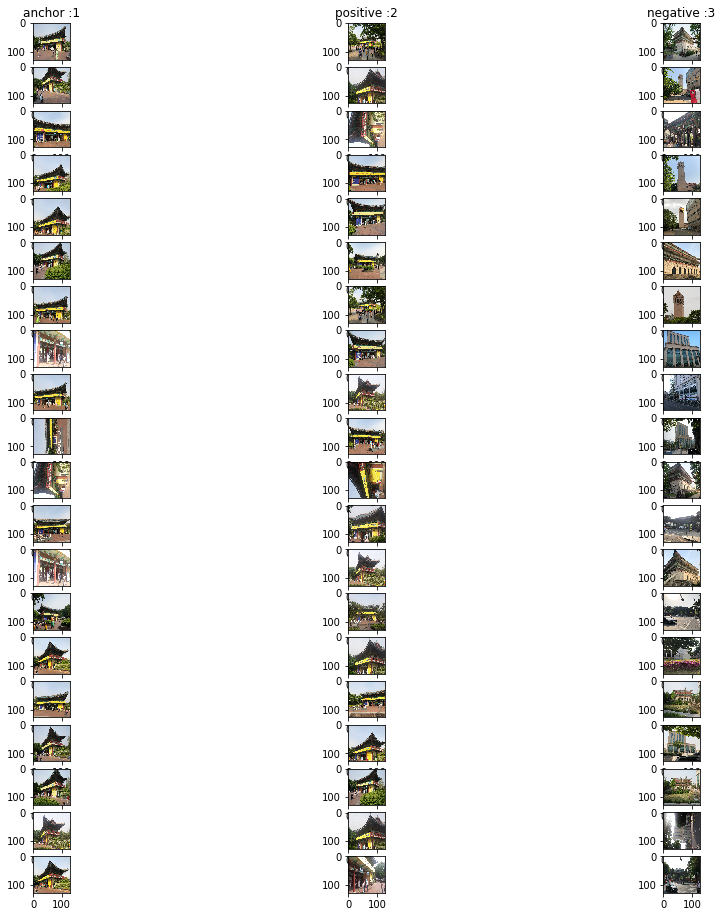

In [17]:
import numpy as np
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(16, 16))
columns = 3
rows = 20
ax = []

idx = 0
for i in range(rows):
  for j in range(columns):
    idx+=1
    ax.append( fig.add_subplot(rows, columns, idx) )
    if idx<=3:
      if idx%3==1:
        ax[-1].set_title("anchor :"+str(idx))  # set title
      elif idx%3==2:
        ax[-1].set_title("positive :"+str(idx))  # set title
      else :
        ax[-1].set_title("negative :"+str(idx))  # set title
    plt.imshow(x_train[i+200,j])

plt.show()

## Shuffle data to an axis

In [0]:
np.random.shuffle(x_train)

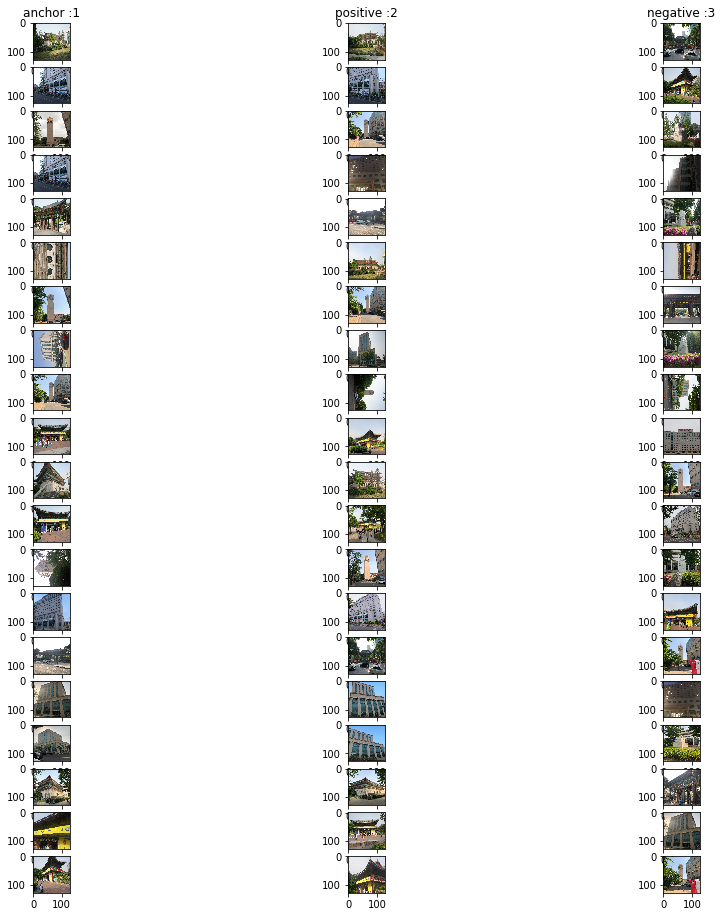

In [19]:
import numpy as np
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(16, 16))
columns = 3
rows = 20
ax = []

idx = 0
for i in range(rows):
  for j in range(columns):
    idx+=1
    ax.append( fig.add_subplot(rows, columns, idx) )
    if idx<=3:
      if idx%3==1:
        ax[-1].set_title("anchor :"+str(idx))  # set title
      elif idx%3==2:
        ax[-1].set_title("positive :"+str(idx))  # set title
      else :
        ax[-1].set_title("negative :"+str(idx))  # set title
    plt.imshow(x_train[i+200,j])

plt.show()

## Loss and Entire Model

In [0]:
##https://codepad.co/snippet/triplet-loss-in-keras-tensorflow-backend

def lossless_triplet_loss(y_true, y_pred, N = 3584, epsilon=1e-4):
    """
    Implementation of the triplet loss function
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    N  --  The number of dimension 
    beta -- The scaling factor, N is recommended
    epsilon -- The Epsilon value to prevent ln(0)
    
    
    Returns:
    loss -- real number, value of the loss
    """
    anchor = y_pred[:,0:N]
    print(anchor.shape)
    positive = y_pred[:,N:N*2]
    print(positive.shape)
    negative = y_pred[:,N*2:N*3]
    print(negative.shape)
    # distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),1)
    
    # distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),1)
    
    #Non Linear Values  
    
    # -ln(-x/N+1)
#     pos_dist = -tf.log(-tf.divide((pos_dist),N)+1+epsilon)
#     neg_dist = -tf.log(-tf.divide((N-neg_dist),N)+1+epsilon)
    
    # compute loss
    triplet_loss = tf.reduce_mean(tf.maximum(pos_dist - neg_dist + epsilon, 0.))
    
    return triplet_loss
  
def load_model(input_shape,base_model,net_vlad):
    
    anchor = Input(shape=(input_shape[0],input_shape[1],input_shape[2]),name='anchor_input')
    pos = Input(shape=(input_shape[0],input_shape[1],input_shape[2]),name='positive_input')
    neg = Input(shape=(input_shape[0],input_shape[1],input_shape[2]),name='negative_input')
    
    anchor_feature=base_model(anchor)
    pos_feature=base_model(pos)
    neg_feature=base_model(neg)
    
    anchor_vlad = net_vlad(anchor_feature)
    pos_vlad = net_vlad(pos_feature)
    neg_vlad = net_vlad(neg_feature)
    
    
    
#     loss = merge([anchor_vlad, pos_vlad, neg_vlad],mode=triplet_loss, name='loss', output_shape=(1,))
    
#     model = Model(inputs=[anchor_example, positive_example, negative_example],
#                   outputs=loss)
    merged_vector = concatenate([anchor_vlad, pos_vlad, neg_vlad], axis=-1)

    # Define the trainable model
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    model = Model(inputs=[anchor, pos, neg], outputs=merged_vector)
#     model.compile(optimizer=Adam(), loss=triplet_loss, metrics=[accuracy])
    model.compile(optimizer=sgd,loss=lossless_triplet_loss)
#     model.compile(loss='mean_absolute_error', optimizer=Adam())
    return model
    

In [0]:
# xa=base_model(tf.convert_to_tensor(x_train[0:5,0], np.float32))
# xp=base_model(tf.convert_to_tensor(x_train[0:5,1], np.float32))
# xn=base_model(tf.convert_to_tensor(x_train[0:5,2], np.float32))

In [0]:
input_shape=(128,128,3)

## Load model

In [23]:
net_vlad = NetVLADLayer(7)
model = load_model(input_shape,base_model,net_vlad)

(?, ?)
(?, ?)
(?, ?)


In [0]:
# a=net_vlad(xa)
# p=net_vlad(xp)
# n=net_vlad(xn)

In [0]:
# xe=concatenate([a,p,n],axis=-1)

In [0]:
# sess=tf.Session()
# sess.run(tf.global_variables_initializer())

In [0]:
# array = xe.eval(session=sess)
# array2 = p.eval(session=sess)

In [0]:
# print(array.shape)
# # print(array[:,4608:4608*2])

In [0]:
# print(array2.shape)
# # print(array2)

In [0]:
# pred=lossless_triplet_loss(0,xe)

In [0]:
# pred.eval(session=sess)

In [32]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 4, 4, 512)    14714688    anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

In [0]:
num_epochs = 15
batch_size = 64

In [34]:
# train shape : (batchsize, triplet, width, height, channel)
x_train.shape

(700, 3, 128, 128, 3)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# get x_train length
total_len=x_train.shape[0] 

# steps_per_epoch * batch size = dataset size
steps_per_epoch = int(total_len/ batch_size)
gen1 = ImageDataGenerator(rotation_range=15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.2,
                         zoom_range=0.1,
                         horizontal_flip=True,
                         fill_mode='nearest')
gen2 = ImageDataGenerator(rotation_range=15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.2,
                         zoom_range=0.1,
                         horizontal_flip=True,
                         fill_mode='nearest')
gen3 = ImageDataGenerator(rotation_range=15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.2,
                         zoom_range=0.1,
                         horizontal_flip=True,
                         fill_mode='nearest')

# dummy = gen1.flow(x_train[:,0],np.ones(x_train[:,0].shape[0]),batch_size = 5,shuffle=False)
# dummy2 = gen2.flow(x_train[:,1],np.ones(x_train[:,1].shape[0]),batch_size = 5,shuffle=False)
# dummy3 = gen3.flow(x_train[:,2],np.ones(x_train[:,2].shape[0]),batch_size = 5,shuffle=False)
def gen_triplet_img(a, p, n, batch_size):

    a_flow = gen1.flow(a, np.ones(a.shape[0]), batch_size = batch_size,shuffle=False)
    p_flow = gen2.flow(p, np.ones(p.shape[0]), batch_size = batch_size,shuffle=False)
    n_flow = gen3.flow(n, np.ones(n.shape[0]), batch_size = batch_size,shuffle=False)
    while True:
        A = a_flow.__next__()
        P = p_flow.__next__()
        N = n_flow.__next__()
        yield [A[0], P[0], N[0]], np.ones(A[0].shape)

In [36]:
if train_test :
  hist = model.fit_generator(gen_triplet_img(x_train[:,0],x_train[:,1],x_train[:,2],batch_size),
                             steps_per_epoch= steps_per_epoch, epochs=num_epochs)
  model.save_weights(os.path.join(ckpt_path,"model_{}.h5".format(num_epochs)))
  print('save weights')
  
else :
  model.load_weights(os.path.join(ckpt_path,"model_{}.h5".format(num_epochs))) 
  print("Loaded weights from colab")

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
10/10 [==============================] - 21s 2s/step - loss: 0.0068
Epoch 2/15
10/10 [==============================] - 16s 2s/step - loss: 0.0023
Epoch 3/15
10/10 [==============================] - 9s 866ms/step - loss: 0.0010
Epoch 4/15
10/10 [==============================] - 9s 871ms/step - loss: 5.8975e-04
Epoch 5/15
10/10 [==============================] - 9s 883ms/step - loss: 4.7810e-04
Epoch 6/15
10/10 [==============================] - 9s 875ms/step - loss: 4.0554e-04
Epoch 7/15
10/10 [==============================] - 9s 866ms/step - loss: 3.8762e-04
Epoch 8/15
10/10 [==============================] - 9s 856ms/step - loss: 2.7562e-04
Epoch 9/15
10/10 [==============================] - 8s 846ms/step - loss: 2.7042e-04
Epoch 10/15
10/10 [==============================] - 8s 847ms/step - loss: 2.4381e-04
Epoch 11/15
10/10 [==============================] - 8s 849ms/step - loss: 2.1879e-04
Epoch 12/15
10/10 [============

In [0]:
# array_to_img(dummy.__next__()[0][0])

In [0]:
# array_to_img(dummy2.__next__()[0][0])

In [0]:
# array_to_img(dummy3.__next__()[0][0])

## Test Data Generator

In [40]:
from keras.preprocessing.image import ImageDataGenerator


test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory(test_path,
                                                 target_size = (128, 128),
                                                 batch_size = 256,
                                                 class_mode = 'binary')


Found 78 images belonging to 7 classes.


In [41]:
idx = 0
x_test = None
y_test = None
for x, y in test_set:
  idx+=1
  x_test = x
  y_test = np.array([int(i) for i in y])
  print(x.shape)
  print(y.shape)
  if idx==1:
    break

(78, 128, 128, 3)
(78,)


In [0]:
from PIL import Image
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y_test[i]),
                 color=plt.cm.Set1(y_test[i] / 7.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


In [0]:
# input array shape : ( batch_size, width , height, channel )
def getVector(array,model):
  tensor=tf.convert_to_tensor(array, np.float32)
  vector_set=model([tensor,tensor,tensor])
  vec_len=vector_set.shape.as_list()[-1]
  vec_len=int(vec_len/3)
  np_eval=K.eval(vector_set)
  result_vector=np_eval[:,:vec_len]
  
  print('got vector shape :',result_vector.shape)
  return result_vector

In [44]:
np_x_test=getVector(x_test,model)

got vector shape : (78, 3584)


Computing t-SNE embedding


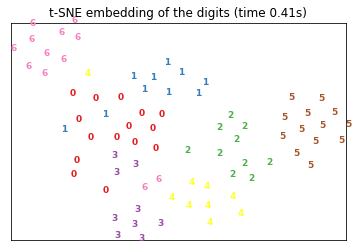

In [45]:
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(np_x_test)

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets, metrics

X = np_x_test
Y = y_test

clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
clf.fit(X, Y) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

</br>

### 고차원 공간에서 거리 구하기 (KNN)

In [0]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=7, algorithm ='ball_tree').fit(np_x_test)

In [48]:
x_test.shape

(78, 128, 128, 3)

## Test Image

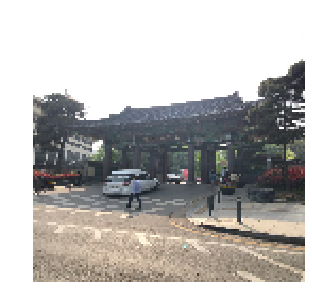

In [49]:
# TEST IMAGE

point_idx = 0
test_img = array_to_img(x_test[point_idx])

plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(test_img)

In [0]:
query_input = x_test[point_idx:point_idx+1]
query_label = y_test[point_idx]
reference_input = x_test
reference_label = y_test

In [51]:
print('query label :',query_label)
print('reference label set :',reference_label)

query label : 3
reference label set : [3 0 0 2 0 6 5 4 0 2 6 0 1 5 4 5 0 6 3 0 0 5 5 1 3 2 6 1 5 1 4 5 6 5 0 3 2
 0 6 6 5 6 0 1 5 0 1 3 5 2 2 0 3 3 5 5 4 1 1 0 3 1 2 2 0 6 4 6 3 2 4 4 6 2
 6 4 4 1]


In [52]:
test_img_vec = getVector(query_input,model)
distances, indices = nbrs.kneighbors(test_img_vec)

got vector shape : (1, 3584)



</br>

## 가장 유사한 이미지 Top 5

In [0]:
import itertools

keys = np.ndarray.tolist(indices[0]) 
values = np.ndarray.tolist(distances[0]) 

find_dict = dict(zip(keys,values)) 

In [0]:
similar = sorted(find_dict.items(), key=lambda find_dict: values)[:5]
similar_idx = [i[0] for i in similar]

In [55]:
similar_idx

[0, 53, 24, 18, 47]

## Result

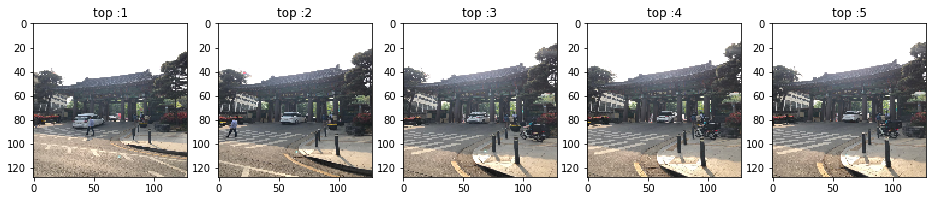

In [56]:
fig=plt.figure(figsize=(16, 16))
columns = 5
rows = 1
ax = []

idx = 0
for i in range(rows):
  for j in similar_idx:
    idx+=1
    ax.append( fig.add_subplot(rows, columns, idx) )
    ax[-1].set_title("top :"+str(idx))  # set title
    plt.imshow(x_test[j])

plt.show()